# 1D Inversion for Multiple Soundings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simpeg import (
    data,
)
from simpeg.utils import plot_1d_layer_model
import pickle
from forward_freq_survey import Forward_Freq_Survey
from layered_inversion import LayeredInversion

### Load Data and Plot

In [2]:
# path to the directory containing our data
dir_path = "../forward_data/batch_simulation0/" # or something else
filename = "forward_simulation_data_15.pkl" # or something else

# files to work with
data_filename = dir_path + filename

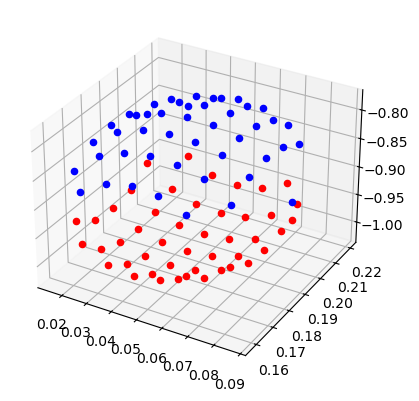

In [3]:
with open(data_filename, "rb") as file:  # Open the file in read-binary mode
    loaded_data, loaded_earth = pickle.load(file)

x_vals = np.linspace(-0.25, 0.25, 50)
y_vals = np.linspace(-0.25, 0.25, 50)

# plot the surface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for x in x_vals:
    for y in y_vals:
        z = loaded_earth.uxo_object.get_vertical_intersects(x, y)
        if z is not None:
            ax.scatter(x, y, z[0], c='b')
            ax.scatter(x, y, z[1], c='r')
plt.show()

In [4]:
uxo_indx = []
for i in range(len(loaded_data)):
    x = float(loaded_data[i]['x'])
    y = float(loaded_data[i]['y'])
    layers, _ = loaded_earth.layers_at_pt((x, y))
    if len(layers) > 0:
        uxo_indx.append(i)

In [5]:
print(uxo_indx)

[1341, 1342, 1343, 1344, 1345, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1641, 1642, 1643, 1644, 1645, 1693]


In [6]:
z0 = 0.1
moment = 1
coil_spacing = 1
soil_conductivity = 0.01 # estimated soil conductivity
frequencies  = loaded_data[0]['frequencies']

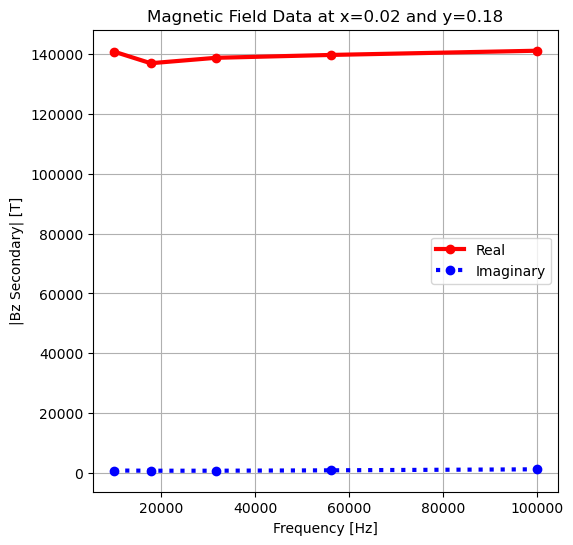

In [7]:
index = 1
x = loaded_data[uxo_indx[index]]["x"]
y = loaded_data[uxo_indx[index]]["y"]
# Plot FEM response for all frequencies
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(frequencies, abs(loaded_data[uxo_indx[index]]["hz_real"]), "r-o", lw=3)
ax.plot(frequencies, abs(loaded_data[uxo_indx[index]]["hz_imag"]), "b:o", lw=3)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("|Bz Secondary| [T]")
ax.set_title(f"Magnetic Field Data at x={round(x,2)} and y={round(y,2)}")
ax.legend(["Real", "Imaginary"])
plt.grid()
plt.show()

## Perform Inversions on Soundings at All Positions

In [8]:
def create_data_object(loaded_data, survey, error=0.05):
    hz_real = loaded_data['hz_real']
    hz_imag = loaded_data['hz_imag']
    dobs = np.empty(len(hz_real)+len(hz_imag))
    dobs[0::2] = hz_real
    dobs[1::2] = hz_imag
    uncertainties = error * np.abs(dobs) * np.ones_like(dobs)
    data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)
    return data_object

In [9]:
# define simulation
freq_survey = Forward_Freq_Survey(frequencies, z0, moment, coil_spacing)

In [12]:
survey = freq_survey.survey
dpred_list = []
recovered_model_list = []
inversion_list = []
for i, data_index in enumerate(uxo_indx):
        print(i + "/" + len(uxo_indx) + "simulation started...")
        data_object = create_data_object(loaded_data[data_index], survey)
        # Initialize LayeredInversion with current data_object and simulation parameters
        layered_inversion = LayeredInversion(
                data_object=data_object, 
                survey=survey, 
                referece_conductivity=soil_conductivity*10**3,
                beta0_ratio=1e-1,
        )
        # Run the inversion and store the recovered model
        m = layered_inversion.run_inversion()
        d = layered_inversion.simulation.dpred(m)

        inversion_list.append(layered_inversion)
        recovered_model_list.append(m)
        dpred_list.append(d)



Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.58e+07  2.01e+07  0.00e+00  2.01e+07    8.51e+06      0              
   1  2.58e+07  5.53e+06  1.51e-01  9.42e+06    1.20e+07      0              
   2  1.72e+07  3.31e+06  9.64e-02  4.96e+06    3.59e+06      0              
   3  1.72e+07  1.54e+06  1.35e-01  3.86e+06    7.42e+05      0   Skip BFGS  
   4  1.15e+07  1.87e+06  1.06e-01  3.08e+06    4.71e+05      1              
   5  1.15e+07  1.20e+06  1.60e-01  3.04e+06    4.88e+05      0         

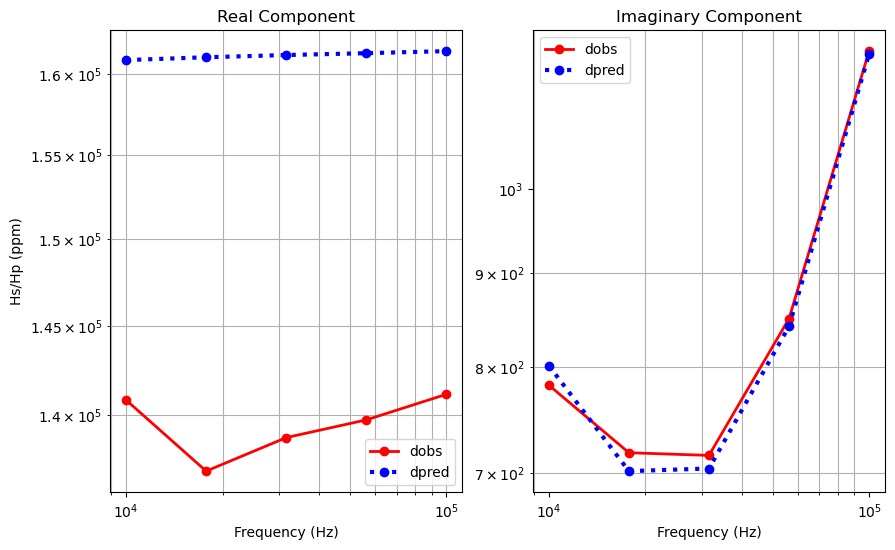

In [15]:
# Plot FEM response for all frequencies at specified index
index = 1
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6))
ax1.loglog(frequencies, abs(loaded_data[uxo_indx[index]]["hz_real"]), "r-o", lw=2, label="dobs")
ax1.loglog(frequencies, dpred_list[index][0::2], "b:o", lw=3, label="dpred")
ax2.loglog(frequencies, abs(loaded_data[uxo_indx[index]]["hz_imag"]), "r-o", lw=2, label="dobs")
ax2.loglog(frequencies, dpred_list[index][1::2], "b:o", lw=3, label="dpred")
ax1.set_ylabel("Hs/Hp (ppm)")
ax1.set_title("Real Component")
ax2.set_title("Imaginary Component")

for ax in [ax1, ax2]:
    ax.set_xlabel("Frequency (Hz)")
    ax.grid(which="both")
    ax.legend()

plt.grid()
plt.show()

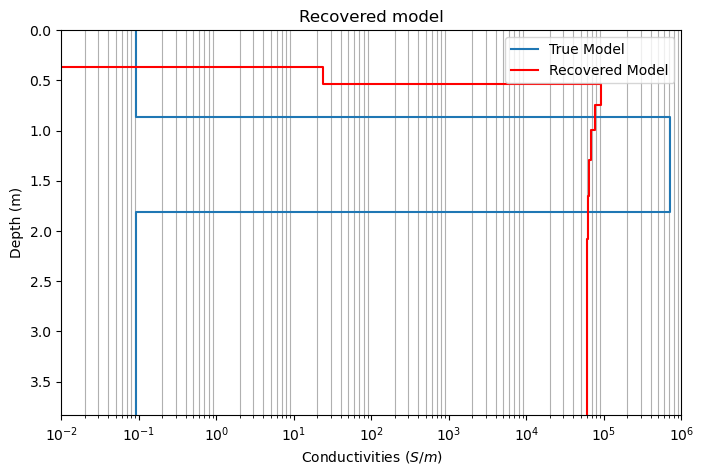

In [118]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

index = 0
try: 
    loaded_earth.plot_layered_earth((loaded_data[uxo_indx[index]]['x'],loaded_data[uxo_indx[index]]['y']), 
                                    ax=ax1)
except:
    plot_1d_layer_model(np.array([3]), 
                        np.array([soil_conductivity]), 
                        scale="log", 
                        color="b", 
                        ax=ax1)

plot_1d_layer_model(inversion_list[index].layer_thicknesses, 
                    inversion_list[index].log_conductivity_map * recovered_model_list[index], 
                    scale="log", 
                    color="r", 
                    ax=ax1)

ax1.set_title("Recovered model")
ax1.legend(["True Model", "Recovered Model"])
ax1.set_xlim([1e-2, 1e6])
ax1.grid()
plt.show()

## Plotting the result in a heat map

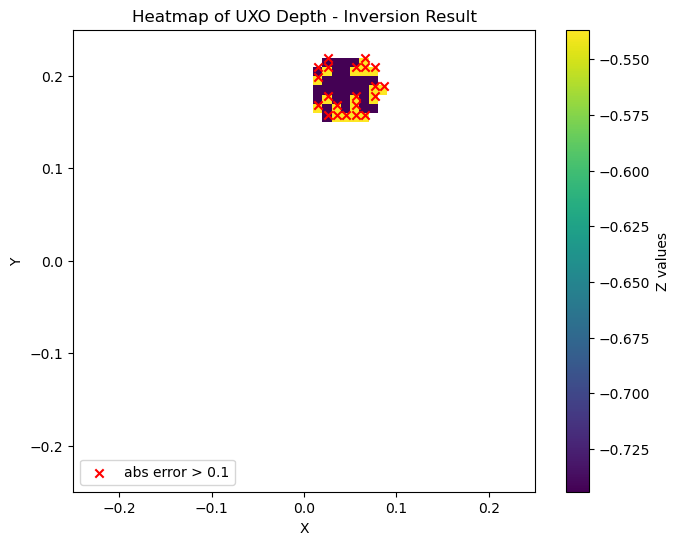

In [117]:
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.ones(X.shape) * 3

plt.figure(figsize=(8, 6))
for i, data_index in enumerate(uxo_indx):
    x = float(loaded_data[data_index]['x'])
    y = float(loaded_data[data_index]['y'])
    idx_x = list(x_vals).index(x)
    idx_y = list(y_vals).index(y)

    temp = list(inversion_list[i].log_conductivity_map * recovered_model_list[i])
    max_index = temp.index(max(temp))
    depth = sum(inversion_list[i].layer_thicknesses[:max_index])
    layers, _ = loaded_earth.layers_at_pt((x, y))
    if layers[0] - depth > 0.1:
        plt.scatter(x, y, color='red', marker='x', label = "abs error > 0.1" if i==0 else "")
    Z[idx_y, idx_x] = -depth

Z_masked = np.where(Z == 3, np.nan, Z)

# Step 4: Plot the heatmap using imshow
plt.imshow(Z_masked, extent=[-0.25, 0.25, -0.25, 0.25], cmap='viridis', origin='lower')
plt.colorbar(label='Z values')  # Show color bar
plt.title('Heatmap of UXO Depth - Inversion Result')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc="lower left")
plt.show()

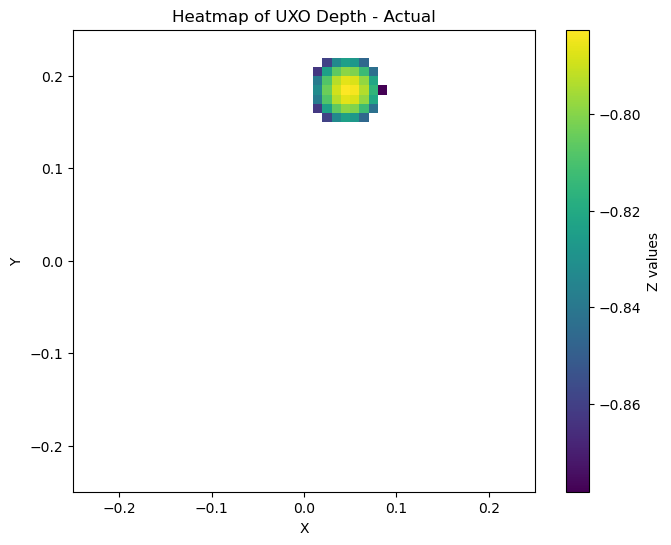

In [115]:
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.ones(X.shape) * 3

for i, data_index in enumerate(uxo_indx):
    x = float(loaded_data[data_index]['x'])
    y = float(loaded_data[data_index]['y'])
    idx_x = list(x_vals).index(x)
    idx_y = list(y_vals).index(y)
    layers, _ = loaded_earth.layers_at_pt((x, y))
    Z[idx_y, idx_x] = -layers[0]

Z_masked = np.where(Z == 3, np.nan, Z)

# Step 4: Plot the heatmap using imshow
plt.figure(figsize=(8, 6))
plt.imshow(Z_masked, extent=[-0.25, 0.25, -0.25, 0.25], cmap='viridis', origin='lower')
plt.colorbar(label='Z values')  # Show color bar
plt.title('Heatmap of UXO Depth - Actual')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Interpolation between Each Recovered Models